In [1]:
import pandas as pd
import numpy as np
import os, sys, shutil
import subprocess
import numpy as np
import xarray as xr
import pickle
import matplotlib
import matplotlib.pyplot as plt

from pyFAST.input_output import TurbSimFile, FASTOutputFile, VTKFile, FASTInputFile
from pyFAST.fastfarm.FASTFarmCaseCreation import FFCaseCreation, modifyProperty
from pyFAST.fastfarm.AMRWindSimulation import AMRWindSimulation
from pyFAST.postpro import equivalent_load

from mmctools.helper_functions import calc_spectra

sys.path.append(os.path.abspath('/home/rthedin/utilities/'))
from helper import interpolate_to_heights, calc_QOIs, calc_spectra_chunks, addScalebar
from helper_fastfarm import readTurbineOutput, readFFPlanes
from coherence import calc_coherence_2signals, plotCoherence, IECCoherence, davenportExpCoh, calcVertCoh, calcLatCoh

def cosd(t): return np.cos(np.deg2rad(t))
def sind(t): return np.sin(np.deg2rad(t))

In [7]:
# ----------- Case absolute path
path = '/projects/car/rthedin/fastfarm/task_ge_2turbines_lesrun_coh_uvw_small_15mw'

# ----------- General hard-coded parameters
cmax     = 5      # maximum blade chord (m)
fmax     = 10/6   # maximum excitation frequency (Hz)
#fmax     = 5   # controls the dt. I want dt=0.1 to match LES, so I will set the appropriate fmax. dt=1/(2f). This was for the single-turbine turbsim-only run
Cmeander = 1.9    # Meandering constant (-)
mod_wake = 1      # Polar

# ----------- Wind farm
D = 240
zhub = 150
wts  = {  # Simple two-turbine farm
          0 :{'x':701.25,         'y':641.25,  'z':0.0,  'D':D,  'zhub':zhub,  'cmax':cmax,  'fmax':fmax,  'Cmeander':Cmeander},
          1 :{'x':1680.0+701.25,  'y':641.25,  'z':0.0,  'D':D,  'zhub':zhub,  'cmax':cmax,  'fmax':fmax,  'Cmeander':Cmeander},
        }
refTurb_rot = 0

# ----------- AMR-Wind parameters
fixed_dt = 0.1
prob_lo = (0.0, 0.0, 0.0)
prob_hi = (3840., 1280.,  960)
n_cell = (1536, 512, 384)
max_level = 0  # Number of grid refinement levels

incflo_velocity_hh = (8.0, 0.0, 0.0)  # Hub-height velocity
postproc_name = 'box'

In [9]:
amr = AMRWindSimulation(wts, fixed_dt, prob_lo, prob_hi,
                        n_cell, max_level, incflo_velocity_hh,
                        postproc_name, buffer_lr = [2.5,6,2.5,2.5,2],
                        mod_wake=mod_wake)

print(f'The high-res spatial resolution is {amr.ds_hr} m,  and the low-res spatial resolution is {amr.ds_lr} m')
print(f'The high-res temporal resolution is {amr.dt_high_les} s, and the low-res temporal resolution is {amr.dt_low_les} s')

The high-res spatial resolution is 5.0 m,  and the low-res spatial resolution is 20.0 m
The high-res temporal resolution is 0.3 s, and the low-res temporal resolution is 5.7 s


In [ ]:
amr.write_sampling_params()

In [12]:
path = '/projects/car/rthedin/amr_runs/04_2turbine_coherencestudy/02_2turbine_neutral_8at150.10dTInv_0.75z0_750zi_3.84x1.28x0.9km_res2.5m_2ref/post_processing'

In [13]:
from windtools.amrwind.post_processing import Sampling

In [14]:

samp = Sampling(os.path.join(path,'planesT1129921.nc'))
samp

Following groups sampled:
    pT1

In [16]:
ds= samp.read_single_group('pT1',itime=0,ftime=100,simCompleted=True)

Reading single group using xarray. This will take longer and require more RAM


In [17]:
ds

<xarray.Dataset>
Dimensions:           (x: 7, y: 201, z: 101, samplingtimestep: 100)
Coordinates:
  * x                 (x) float64 706.2 946.2 1.186e+03 ... 1.906e+03 2.146e+03
  * y                 (y) float64 141.2 146.2 151.2 ... 1.136e+03 1.141e+03
  * z                 (z) float64 11.25 16.25 21.25 26.25 ... 501.2 506.2 511.2
  * samplingtimestep  (samplingtimestep) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
Data variables:
    u                 (y, z, x, samplingtimestep) float64 3.98 3.843 ... 10.56
    v                 (y, z, x, samplingtimestep) float64 0.1857 ... -0.9522
    w                 (y, z, x, samplingtimestep) float64 0.7708 ... -0.1386

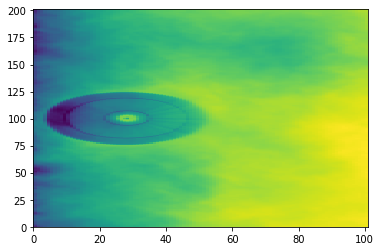

In [20]:
plt.pcolormesh(ds.isel(x=0).mean(dim='samplingtimestep')['u'])